In [ ]:
## check if mount folder exists -- if not create it
!mkdir -p /home/walter_littor_al/geotools_sites
## mount bucket
!gcsfuse coastal_geotools_demo /home/walter_littor_al/geotools_sites

# setup

## installs

In [1]:
%%capture
import sys
import os
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import ee_s2,littoral_sites
import numpy as np  
import cv2
from PIL import Image
import pandas as pd

## folder names

In [2]:
site_table_path = "/home/walter_littor_al/Littoral_S2download/littoral_sites.csv"
save_path = "/home/walter_littor_al/geotools_sites"

## folder names
tiff_folder = "TARGETS"
upsampled_folder = "UP"
normalized_folder = "NORMALIZED"
masked_folder = "MASK"
nir_folder = "RAWNIR"
rgb_folder = "RAWRGB"
cld_output_folder = "CLEAR"
clear_tiff_folder = "/TARGETS/cloudless"


## select site

In [3]:
littoral_sites.load_sites(path=site_table_path)

,id,site_name,aoi,start,end,max_cloudy_pixel_percentage,last_run,periodic
0,1,veyofushi_finolhu,"[\n [\n 73.13560806514303,\n 5.232300220203626\n ],\n [\n 73.14249432985883,\n 5.2376483570647\n ]\n ]",2024-01-01,2024-01-30,10,11/26/24,True
1,2,Vakharu,"[ [\n 73.49705943626319,\n 4.26141802708446\n ],\n [\n 73.50270164253178,\n 4.266148717007908\n ]\n ]",2024-01-01,2024-01-30,10,11/26/24,True
2,3,Fuvahmulah,"[\n [\n 73.40485831620961,\n -0.315466217603003\n ],\n [\n 73.4460947310398,\n -0.27336352803042985\n ]\n ]",2024-01-01,2024-01-30,10,11/26/24,True
3,4,Fenfushi,"[\n [\n 72.898,\n 5.379\n ],\n [\n 72.905,\n 5.3865\n ]\n ]",2024-01-01,2024-01-30,10,NaN,True
4,5,Bodufen,"[\n [\n 72.9211,\n 5.628\n ],\n [\n 72.9259,\n 5.6315\n ]\n ]",2024-01-01,2024-01-30,10,NaN,True
5,6,Goiymaru,"[\n [\n 72.884,\n 5.628\n ],\n [\n 72.891,\n 5.632\n ]\n ]",2024-01-01,2024-01-30,10,NaN,True
6,7,Lun’dhufushi,"[\n [\n 72.981,\n 5.64\n ],\n [\n 72.992,\n 5.647\n ]\n ]",2024-01-01,2024-01-30,10,NaN,True
7,8,Nauset,"[\n [\n -69.92896482901996,\n 41.77570649897041\n ],\n [\n -69.94188594216035,\n 41.78429419017735\n ]\n ]",2024-01-01,2024-01-30,10,NaN,False
8,5,mustique,"[[-61.206378936767585,12.848456541418054],[-61.154708862304695,12.901505084198375]]",2015-01-01,2025-01-01,5,NaN,True
9,6,anhenunfushi,"[[\n 72.95963024376084,\n 5.335849250143042\n ],[\n 72.97657581537973,\n 5.348010027325287\n ]]",2015-01-01,2025-01-01,75,NaN,True


In [4]:
names = littoral_sites.list_site_names(path=site_table_path)
site_name = names[3]
site_name

'Fenfushi'

# Run Pipeline

## download imagery

In [26]:
%%capture
ee_s2.connect()
proj_params = littoral_sites.load_site_parameters_cg(site_name,save_path,site_table_path)

se2_col = ee_s2.get_filtered_image_collection(proj_params) # = ee_s2.get_image_collection(proj_params)

In [25]:
proj_params

{'aoi': [[72.898, 5.379], [72.905, 5.3865]],
 'start_date': '2024-01-01',
 'end_date': '2024-01-30',
 'max_cloudy_pixel_percentage': 10.0,
 'project_name': 'Fenfushi',
 'path': '/home/walter_littor_al/geotools_sites/Fenfushi',
 'periodic': 'True'}

In [6]:
se2_col.size().getInfo()

4

In [8]:
# #ee_s2.process_collection_images_totar(proj_params, se2_col,site_path=site_table_path)
results = ee_s2.process_collection_images_tofiles(proj_params, se2_col)
#save results to csv
df = pd.DataFrame(results)
df.to_csv(f"{save_path}/{site_name}/processing.csv",index=False)

landsat count = 61


In [19]:
# # # %%capture
# # # for name in names:
# # #     proj_params = littoral_sites.load_site_parameters_cg(name,save_path,site_table_path)
# # #     se2_col = ee_s2.get_image_collection(proj_params)
# # #     #ee_s2.process_collection_images_tofiles(proj_params, se2_col)

## coregister

In [14]:
import sys
sys.path.append('/home/walter_littor_al/littoral_coreg/src')
from littoral_coregistration import LittoralCoregistration

In [15]:
# Fix PROJ database context issue
import os
from pyproj import datadir
os.environ['PROJ_DATA'] = '/opt/conda/envs/littoral_pipeline/share/proj'
datadir.set_data_dir('/opt/conda/envs/littoral_pipeline/share/proj')

top_level = save_path + "/" + site_name
print("Top-level directory:", top_level)
# Run the coregistration workflow (no cleanup so we can inspect outputs)
coreg = LittoralCoregistration(top_level)
results = coreg.run(cleanup=True)
print("Result top-level keys:", list(results.keys())[:10])
print("Saved outputs in:", coreg.coregistered_dir)

Top-level directory: /home/walter_littor_al/geotools_sites/Fenfushi
Reference file: ['LC08_146056_20230218.tif']
Target file count: 4
Found 4 files matching pattern '*.tif' in '/home/walter_littor_al/geotools_sites/Fenfushi/TARGETS'.
Found 4 files matching pattern '*.tif' in '/home/walter_littor_al/geotools_sites/Fenfushi/TARGETS'.


Coregistering Images:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(264465.0, 592365.0, 270465.0, 598385.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(264460.0, 592360.0, 270460.0, 598380.0)
Matching window position (X,Y): 267462.5/595372.5
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.25734102725982666/-0.38823896646499634
Calculated total shifts in fft pixel units (X/Y):         -0.25734102725982666/-0.38823896646499634
Calculated total shifts in reference pixel units (X/Y):   -0.25734102725982666/-0.38823896646499634
Calculated total shifts in target pixel units (X/Y):      -0.25734102725982666/-0.38823896646499634
Calculated map shifts (X,Y):                              -2.5734102725982666/3.8823896646499634
Calcula

Coregistering Images:  25%|██▌       | 1/4 [00:02<00:06,  2.10s/it]

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(264465.0, 592365.0, 270465.0, 598385.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(264460.0, 592360.0, 270460.0, 598380.0)
Matching window position (X,Y): 267462.5/595372.5
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           0.2998172640800476/0.36856740713119507
Calculated total shifts in fft pixel units (X/Y):         0.2998172640800476/0.36856740713119507
Calculated total shifts in reference pixel units (X/Y):   0.2998172640800476/0.36856740713119507
Calculated total shifts in target pixel units (X/Y):      0.2998172640800476/0.36856740713119507
Calculated map shifts (X,Y):                              2.998172640800476/-3.6856740713119507
Calculated absolute 

Coregistering Images:  50%|█████     | 2/4 [00:04<00:04,  2.11s/it]

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(264465.0, 592365.0, 270465.0, 598385.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(264460.0, 592360.0, 270460.0, 598380.0)
Matching window position (X,Y): 267462.5/595372.5
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           0.29596447944641113/0.3680063486099243
Calculated total shifts in fft pixel units (X/Y):         0.29596447944641113/0.3680063486099243
Calculated total shifts in reference pixel units (X/Y):   0.29596447944641113/0.3680063486099243
Calculated total shifts in target pixel units (X/Y):      0.29596447944641113/0.3680063486099243
Calculated map shifts (X,Y):                              2.9596447944641113/-3.680063486099243
Calculated absolute 

Coregistering Images:  75%|███████▌  | 3/4 [00:06<00:02,  2.14s/it]

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(264465.0, 592365.0, 270465.0, 598385.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(264460.0, 592360.0, 270460.0, 598380.0)
Matching window position (X,Y): 267462.5/595372.5
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.2992594242095947/0.3941684067249298
Calculated total shifts in fft pixel units (X/Y):         -0.2992594242095947/0.3941684067249298
Calculated total shifts in reference pixel units (X/Y):   -0.2992594242095947/0.3941684067249298
Calculated total shifts in target pixel units (X/Y):      -0.2992594242095947/0.3941684067249298
Calculated map shifts (X,Y):                              -2.9925942420959473/-3.941684067249298
Calculated absolute

Coregistering Images: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]



Saving coregistration results to /home/walter_littor_al/geotools_sites/Fenfushi/coregistered/coreg_results.json
Filtered coregistration results saved to /home/walter_littor_al/geotools_sites/Fenfushi/coregistered/filtered_files.csv
Number of failed coregistrations: 0 / 4 total
No failed coregistrations to move.
Filtered coregistration results saved to /home/walter_littor_al/geotools_sites/Fenfushi/coregistered/filtered_files.csv
Number of failed coregistrations: 0 / 4 total
No failed coregistrations to move.
Successfully deleted the folder: /home/walter_littor_al/geotools_sites/Fenfushi/modified_targets
Successfully deleted the folder: /home/walter_littor_al/geotools_sites/Fenfushi/modified_targets
Successfully deleted the folder: /home/walter_littor_al/geotools_sites/Fenfushi/modified_templates
Workflow complete.
Result top-level keys: ['20240116T052149_20240116T053608_T43NBF.tif', '20240121T052111_20240121T053340_T43NBF.tif', '20240121T052111_20240121T053340_T43NBG.tif', '20240126T05

## cloud impute

In [16]:
import sys
sys.path.append('/home/walter_littor_al/littoral_cloud_impute')

import vpint_cloud_impute
folder_path = save_path + "/" + site_name + "/" + tiff_folder
folder_path

'/home/walter_littor_al/geotools_sites/Fenfushi/TARGETS'

In [17]:
vpint_cloud_impute.batch_remove_clouds_folder(folder_path)

/home/walter_littor_al/VPint/VPint/utils/EO_utils.py:294: RuntimeWarning: load_tiff_windowed: No matching band descriptions found; falling back to sequential mapping by order.
  warnings.warn(
/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Selected features image: 20240121T052111_20240121T053340_T43NBF.tif (cloud=0.055)
Extracting 602x600 window at (0, 0)
[OK] Saved: /home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240116T052149_20240116T053608_T43NBF_pred.tif
[OK] Saved: /home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240116T052149_20240116T053608_T43NBF_pred.tif
Extracting 602x600 window at (0, 0)
Extracting 602x600 window at (0, 0)
[OK] Saved: /home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240121T052111_20240121T053340_T43NBF_pred.tif
[OK] Saved: /home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240121T052111_20240121T053340_T43NBF_pred.tif
Extracting 602x600 window at (0, 0)
Extracting 602x600 window at (0, 0)
[OK] Saved: /home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240121T052111_20240121T053340_T43NBG_pred.tif
[OK] Saved: /home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240121T052111_20240121T053340_T43N

['/home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240116T052149_20240116T053608_T43NBF_pred.tif',
 '/home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240121T052111_20240121T053340_T43NBF_pred.tif',
 '/home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240121T052111_20240121T053340_T43NBG_pred.tif',
 '/home/walter_littor_al/geotools_sites/Fenfushi/TARGETS/cloudless/20240126T052109_20240126T053414_T43NBG_pred.tif']

In [18]:
import pandas as pd
import os

# Find the CSV report in the cloudless folder
cloudless_folder = os.path.join(folder_path, "cloudless")
csv_files = [f for f in os.listdir(cloudless_folder) if f.endswith('.csv')]
report_path = os.path.join(cloudless_folder, csv_files[0])

# Load and display the CSV report
report_df = pd.read_csv(report_path)
report_df.head()

,image_name,image_date,cloud_coverage %,original_image_size,cloudless_image_size,image_CRS,image_Transform,band_names
0,20240116T052149_20240116T053608_T43NBF.tif,2024-01-16T05:21:49,7.16,602x600,602x600,EPSG:32643,"| 10.00, 0.00, 264460.00|\n| 0.00,-10.00, 598380.00|\n| 0.00, 0.00, 1.00|",NaN
1,20240121T052111_20240121T053340_T43NBF.tif,2024-01-21T05:21:11,5.46,602x600,602x600,EPSG:32643,"| 10.00, 0.00, 264460.00|\n| 0.00,-10.00, 598380.00|\n| 0.00, 0.00, 1.00|",NaN
2,20240121T052111_20240121T053340_T43NBG.tif,2024-01-21T05:21:11,5.46,602x600,602x600,EPSG:32643,"| 10.00, 0.00, 264460.00|\n| 0.00,-10.00, 598380.00|\n| 0.00, 0.00, 1.00|",NaN
3,20240126T052109_20240126T053414_T43NBG.tif,2024-01-26T05:21:09,15.42,602x600,602x600,EPSG:32643,"| 10.00, 0.00, 264460.00|\n| 0.00,-10.00, 598380.00|\n| 0.00, 0.00, 1.00|",NaN


## create cloudfree RGB and NIR images

In [5]:
import sys
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import ee_s2

In [6]:
existing_nir_folder = folder_path = save_path + "/" + site_name + "/" + nir_folder
existing_rgb_folder = folder_path = save_path + "/" + site_name + "/" + rgb_folder
clear_output_folder = folder_path = save_path + "/" + site_name + "/" + cld_output_folder
clear_tiff_folder = folder_path = save_path + "/" + site_name + "/" + clear_tiff_folder

# Create the output folders if they don't exist
os.makedirs(clear_output_folder, exist_ok=True)

In [7]:
# Call the function with the existing variables
processed_files = ee_s2.process_cloud_imputed_images(
    existing_nir_folder=existing_nir_folder,
    existing_rgb_folder=existing_rgb_folder, 
    clear_tiff_folder=clear_tiff_folder,
    clear_output_folder=clear_output_folder
)

/home/walter_littor_al/geotools_sites/Fenfushi//TARGETS/cloudless/20240116T052149_20240116T053608_T43NBF_pred.tif
Using band 8 for NIR: /home/walter_littor_al/geotools_sites/Fenfushi//TARGETS/cloudless/20240116T052149_20240116T053608_T43NBF_pred.tif
NIR band stats for /home/walter_littor_al/geotools_sites/Fenfushi//TARGETS/cloudless/20240116T052149_20240116T053608_T43NBF_pred.tif: min=1174.8987141277557, max=6170.0, mean=1399.7174036238944
Saved: /home/walter_littor_al/geotools_sites/Fenfushi/CLEAR/20240116T052149_20240116T053608_T43NBF_nir.png
/home/walter_littor_al/geotools_sites/Fenfushi//TARGETS/cloudless/20240121T052111_20240121T053340_T43NBF_pred.tif
Using band 8 for NIR: /home/walter_littor_al/geotools_sites/Fenfushi//TARGETS/cloudless/20240121T052111_20240121T053340_T43NBF_pred.tif
NIR band stats for /home/walter_littor_al/geotools_sites/Fenfushi//TARGETS/cloudless/20240121T052111_20240121T053340_T43NBF_pred.tif: min=980.1290978680952, max=7643.0, mean=1296.5901203775643
Saved:

## upsample

In [5]:
import sys
sys.path.append('/home/walter_littor_al/Real-ESRGAN')
from RealESRGAN.model import RealESRGAN
import RealESRGAN.model as re

/home/walter_littor_al/Real-ESRGAN/RealESRGAN/model.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()


In [6]:
# # upsample from tar
# re.upsample_tar('geotools_sites/Fenfushi')
up_input = save_path + "/" + site_name + '/' + cld_output_folder
up_input

'/home/walter_littor_al/geotools_sites/Fenfushi/CLEAR'

In [7]:
upsampled_images = re.upsample_folder(up_input)
upsampled_images

upsampling images from: /home/walter_littor_al/geotools_sites/Fenfushi/CLEAR


['/home/walter_littor_al/geotools_sites/Fenfushi/UP/20240116T052149_20240116T053608_T43NBF_nir_up.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/UP/20240116T052149_20240116T053608_T43NBF_rgb_up.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/UP/20240121T052111_20240121T053340_T43NBF_nir_up.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/UP/20240121T052111_20240121T053340_T43NBF_rgb_up.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/UP/20240121T052111_20240121T053340_T43NBG_nir_up.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/UP/20240121T052111_20240121T053340_T43NBG_rgb_up.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/UP/20240126T052109_20240126T053414_T43NBG_nir_up.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/UP/20240126T052109_20240126T053414_T43NBG_rgb_up.png']

## remove defective images and normalize good images

In [30]:
import os
import glob
from PIL import Image
import numpy as np

up_folder = save_path + "/" + site_name + '/' + upsampled_folder
norm_out_folder = save_path + "/" + site_name + '/' + normalized_folder

os.makedirs(normalized_folder, exist_ok=True)
nir_images = glob.glob(os.path.join(up_folder, '*_nir_up.png'))

for img_path in nir_images:
    img = Image.open(img_path)
    arr = np.array(img)
    # check if any pixel values are between 25 and 230
    if np.any((arr > 25) & (arr < 230)):
        #image has grey values - normalize
        arr = ((arr - arr.min()) / (np.ptp(arr) + 1e-6) * 255).astype(np.uint8)
        out_path = os.path.join(norm_out_folder, os.path.basename(img_path))
        Image.fromarray(arr).save(out_path)
    else:
        #image has no grey values - skip
        print(f"Skipping normalization for {img_path} - no grey values")
        continue

## segmentation

In [5]:
import sys
sys.path.append('/home/walter_littor_al/littoral_segment')
from seg_models.yolov8_seg import YOLOV8
YOLO_STD = YOLOV8(folder='/home/walter_littor_al/littoral_segment/seg_models/yolo8_params')

In [6]:
seg_imput_folder = save_path + "/" + site_name + '/'+ normalized_folder
seg_imput_folder

'/home/walter_littor_al/geotools_sites/Fenfushi/NORMALIZED'

In [7]:
mask_paths = YOLO_STD.mask_from_folder(seg_imput_folder)
mask_paths


0: 640x608 1 island, 77.9ms
Speed: 2.3ms preprocess, 77.9ms inference, 157.7ms postprocess per image at shape (1, 3, 640, 608)
0: 640x608 1 island, 77.9ms
Speed: 2.3ms preprocess, 77.9ms inference, 157.7ms postprocess per image at shape (1, 3, 640, 608)


0: 640x608 1 island, 70.9ms
Speed: 2.6ms preprocess, 70.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)
0: 640x608 1 island, 70.9ms
Speed: 2.6ms preprocess, 70.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


0: 640x608 1 island, 67.9ms
Speed: 2.1ms preprocess, 67.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)
0: 640x608 1 island, 67.9ms
Speed: 2.1ms preprocess, 67.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


0: 640x608 1 island, 67.8ms
Speed: 2.0ms preprocess, 67.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)
0: 640x608 1 island, 67.8ms
Speed: 2.0ms preprocess, 67.8ms inference, 1.8ms postprocess per image at shape (1, 3,

['/home/walter_littor_al/geotools_sites/Fenfushi/MASK/20240116T052149_20240116T053608_T43NBF_nir_mask.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/MASK/20240121T052111_20240121T053340_T43NBF_nir_mask.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/MASK/20240121T052111_20240121T053340_T43NBG_nir_mask.png',
 '/home/walter_littor_al/geotools_sites/Fenfushi/MASK/20240126T052109_20240126T053414_T43NBG_nir_mask.png']

## batch process shorelines

In [27]:
sys.path.append('/home/walter_littor_al')
from littoral_refine import extract_boundary 
from littoral_refine import refine_boundary
# from littoral_refine import boundary_filter # filtering integrated into refinement

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import logging

In [6]:
mask_folder = save_path + "/" + site_name + '/MASK'
shoreline_paths = extract_boundary.get_shorelines_from_folder(mask_folder)

In [7]:
refine_boundary.refine_shorelines(save_path + "/" + site_name)

Skipping filtering, only 4 shorelines found.
Refining 4 shorelines...
20240116T052149_20240116T053608_T43NBF
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Fenfushi/SHORELINE/20240116T052149_20240116T053608_T43NBF_nir_rl.csv
20240121T052111_20240121T053340_T43NBF
20240121T052111_20240121T053340_T43NBF
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Fenfushi/SHORELINE/20240121T052111_20240121T053340_T43NBF_nir_rl.csv
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Fenfushi/SHORELINE/20240121T052111_20240121T053340_T43NBF_nir_rl.csv
20240121T052111_20240121T053340_T43NBG
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Fenfushi/SHORELINE/20240121T052111_20240121T053340_T43NBG_nir_rl.csv
20240121T052111_20240121T053340_T43NBG
Saving refined shoreline to: /home/walter_littor_al/geotools_sites/Fenfushi/SHORELINE/20240121T052111_20240121T053340_T43NBG_nir_rl.csv
20240126T052109_20240126T053414_T43NBG
Saving refined s

'/home/walter_littor_al/geotools_sites/Fenfushi/processing.csv'

# Prepare Shorelines for Analysis

## geotransform shorelines

In [8]:
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import geo_transform

/opt/conda/envs/littoral_pipeline/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [9]:
cloudless_report_path = save_path + "/" + site_name + "/" + tiff_folder + "/cloudless/cloudless_report.csv"
coreg_path = save_path + "/" + site_name + "/coregistered/filtered_files.csv"
shoreline_path = save_path + "/" + site_name + "/SHORELINE"

In [10]:
geo_transform.batch_geotransform(shoreline_path,cloudless_report_path,coreg_path)

## filter and preview geotransformed shorelines

In [7]:
shoreline_path = save_path + "/" + site_name + "/SHORELINE"

geo_files = [f for f in os.listdir(shoreline_path) if f.endswith('o.csv')]
len(geo_files)

4

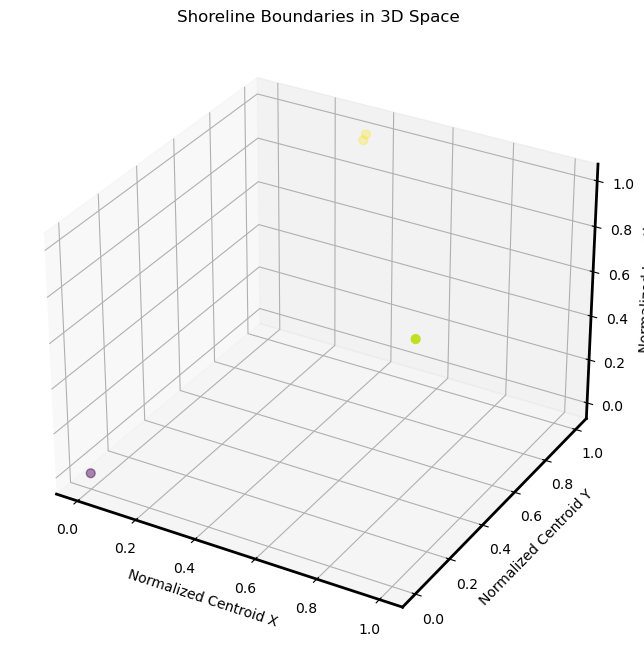

In [8]:
import pandas as pd
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

centroids = []
lengths = []

for csv_file in geo_files:
    csv_path = os.path.join(shoreline_path, csv_file)
    df = pd.read_csv(csv_path)
    x = df.iloc[:, 0].values
    y = df.iloc[:, 1].values

    # Calculate centroid
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)
    centroids.append((centroid_x, centroid_y))

    # Calculate polyline length
    dx = np.diff(x)
    dy = np.diff(y)
    segment_lengths = np.sqrt(dx**2 + dy**2)
    total_length = np.sum(segment_lengths)
    lengths.append(total_length)

centroids = np.array(centroids)
lengths = np.array(lengths)

# Normalize centroid coordinates and lengths to [0, 1]
centroid_x_norm = (centroids[:, 0] - centroids[:, 0].min()) / (np.ptp(centroids[:, 0]) + 1e-6)
centroid_y_norm = (centroids[:, 1] - centroids[:, 1].min()) / (np.ptp(centroids[:, 1]) + 1e-6)
lengths_norm = (lengths - lengths.min()) / (np.ptp(lengths) + 1e-6)

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centroid_x_norm, centroid_y_norm, lengths_norm, c=lengths_norm, cmap='viridis', s=40)
ax.set_xlabel('Normalized Centroid X')
ax.set_ylabel('Normalized Centroid Y')
ax.set_zlabel('Normalized Length')
ax.set_title('Shoreline Boundaries in 3D Space')
plt.show()

In [9]:
from sklearn.cluster import DBSCAN
import numpy as np

def filter_main_cluster(x, y, lengths_norm, eps=0.05, min_samples=10):
    """
    Identifies the main cluster in 3D space and removes outliers.

    Args:
        x (np.ndarray): X coordinates (normalized or raw).
        y (np.ndarray): Y coordinates (normalized or raw).
        lengths_norm (np.ndarray): Normalized lengths.
        eps (float): DBSCAN epsilon (distance threshold).
        min_samples (int): Minimum samples for a cluster.

    Returns:
        mask (np.ndarray): Boolean mask for points in the main cluster.
    """
    points = np.stack([x, y, lengths_norm], axis=1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_
    # Find the largest cluster (excluding noise label -1)
    unique, counts = np.unique(labels[labels != -1], return_counts=True)
    if len(counts) == 0:
        # No clusters found, return all as outliers
        return np.zeros_like(labels, dtype=bool)
    main_cluster = unique[np.argmax(counts)]
    mask = labels == main_cluster
    return mask



In [10]:

mask = filter_main_cluster(centroid_x_norm, centroid_y_norm, lengths_norm)

#apply the mask to the geo_files list
if len(geo_files) < 50:
    filtered_geo_files = geo_files
else:
    filtered_geo_files = [geo_files[i] for i in range(len(geo_files)) if mask[i]]
len(filtered_geo_files)

4

In [11]:
import numpy as np
import pandas as pd
import os
from geomdl import BSpline, utilities

def get_datetime_from_filename(filename):
    # Assumes format: YYYYMMDDTHHMMSS...
    return pd.to_datetime(filename[:15], format='%Y%m%dT%H%M%S')

def get_spline_and_normals(x, y, num_points=200):
    points = list(zip(x, y))
    if points[0] != points[-1]:
        points.append(points[0])
    curve = BSpline.Curve()
    curve.degree = min(3, len(points) - 1)
    curve.ctrlpts = points
    curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts))
    curve.delta = 1.0 / (num_points - 1)
    spline_points = np.array(curve.evalpts)
    normals = []
    for j in range(len(spline_points)):
        if j == 0:
            tangent = spline_points[j+1] - spline_points[j]
        elif j == len(spline_points) - 1:
            tangent = spline_points[j] - spline_points[j-1]
        else:
            tangent = spline_points[j+1] - spline_points[j-1]
        normal = np.array([-tangent[1], tangent[0]])
        norm_len = np.linalg.norm(normal)
        normals.append(normal / norm_len if norm_len > 0 else np.zeros_like(normal))
    return spline_points, np.array(normals)

def find_closest_point_and_distance(pt, other_spline):
    """
    Find the closest point on other_spline to pt and return distance and direction vector.
    
    Returns:
        distance (float): Distance to closest point
        direction (np.array): Direction vector from pt to closest point
    """
    distances = np.linalg.norm(other_spline - pt, axis=1)
    closest_idx = np.argmin(distances)
    closest_point = other_spline[closest_idx]
    distance = distances[closest_idx]
    direction = closest_point - pt
    # Normalize direction vector
    if distance > 0:
        direction = direction / distance
    else:
        direction = np.array([0, 0])
    return distance, direction

# Sort shorelines by datetime
shoreline_info = []
for fname in filtered_geo_files:
    dt = get_datetime_from_filename(fname)
    shoreline_info.append((dt, fname))
shoreline_info.sort()
sorted_files = [f for _, f in shoreline_info]

# Precompute splines and normals for all shorelines
shoreline_splines = []
shoreline_normals = []
for fname in sorted_files:
    df = pd.read_csv(os.path.join(shoreline_path, fname))
    x = df['xm'].values if 'xm' in df.columns else df.iloc[:, 0].values
    y = df['ym'].values if 'ym' in df.columns else df.iloc[:, 1].values
    spline, normals = get_spline_and_normals(x, y)
    shoreline_splines.append(spline)
    shoreline_normals.append(normals)

# First loop: Calculate overall average distance across all shorelines
all_distances = []
for i in range(1, len(shoreline_splines) - 1):
    curr_spline = shoreline_splines[i]
    prev_spline = shoreline_splines[i-1]
    next_spline = shoreline_splines[i+1]
    
    for pt in curr_spline:
        dist_prev, _ = find_closest_point_and_distance(pt, prev_spline)
        dist_next, _ = find_closest_point_and_distance(pt, next_spline)
        all_distances.extend([dist_prev, dist_next])

# Calculate global mean distance
global_mean_dist = np.mean(all_distances)
print(f"Global mean distance: {global_mean_dist:.3f}")
print(f"Total shorelines available for filtering: {len(shoreline_splines)}")

# Only apply defective shoreline filtering if we have more than 50 shorelines
if len(shoreline_splines) > 50:
    print("Applying defective shoreline filtering (>50 shorelines available)")
    # Filtering step using distance and direction criteria
    defective_indices = set()
    for i in range(1, len(shoreline_splines) - 1):
        curr_spline = shoreline_splines[i]
        prev_spline = shoreline_splines[i-1]
        next_spline = shoreline_splines[i+1]
        
        defective_points = 0
        total_points = len(curr_spline)
        
        for pt in curr_spline:
            dist_prev, dir_prev = find_closest_point_and_distance(pt, prev_spline)
            dist_next, dir_next = find_closest_point_and_distance(pt, next_spline)
            
            # Check if distances are 5 times the average
            if dist_prev > 5 * global_mean_dist or dist_next > 5 * global_mean_dist:
                # Check if direction vectors are within 90 degrees (dot product > 0)
                # If dot product > 0, angle is < 90 degrees
                dot_product = np.dot(dir_prev, dir_next)
                if dot_product > 0:  # Directions are closer than 90 degrees
                    defective_points += 1
        
        # If more than 10% of points are defective, mark the shoreline as defective
        if defective_points > 0.1 * total_points:
            defective_indices.add(i)
            print(f"Shoreline {i} marked as defective: {defective_points}/{total_points} defective points")
    
    # Filter out defective shorelines
    filtered2_sorted_files = [sorted_files[i] for i in range(len(sorted_files)) if i not in defective_indices]
    # get the defective filenames
    defective_files = [sorted_files[i] for i in defective_indices]
    
    print(f"Filtered out {len(defective_indices)} defective shorelines.")
    print(f"Remaining shorelines: {len(filtered2_sorted_files)}")
else:
    print("Skipping defective shoreline filtering (≤50 shorelines available)")
    print("Using all shorelines without defective filtering")
    # Use all shorelines without filtering
    filtered2_sorted_files = sorted_files.copy()
    defective_files = []
    defective_indices = set()
    
    print(f"Total shorelines used: {len(filtered2_sorted_files)}")

Global mean distance: 12.702
Total shorelines available for filtering: 4
Skipping defective shoreline filtering (≤50 shorelines available)
Using all shorelines without defective filtering
Total shorelines used: 4


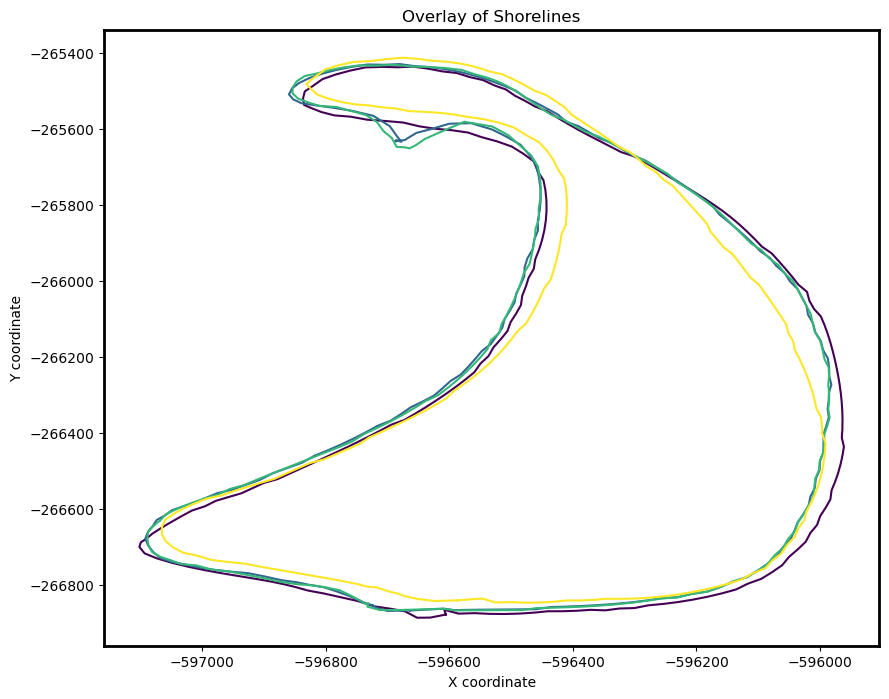

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for idx, csv_file in enumerate(filtered2_sorted_files):
    csv_path = os.path.join(shoreline_path, csv_file)
    df = pd.read_csv(csv_path)
    x = df.iloc[:, 1].tolist()
    y = df.iloc[:, 0].tolist()

    # Invert the y-axis
    y = [-val for val in y]
    x = [-val for val in x]

    # Close the curve by appending the first point to the end
    x.append(x[0])
    y.append(y[0])
    color = plt.cm.viridis(idx / max(len(filtered2_sorted_files) - 1, 1))
    plt.plot(x, y, linestyle='-', label=csv_file, color=color)

#show the defective files in red
for idx, csv_file in enumerate(defective_files):
    csv_path = os.path.join(shoreline_path, csv_file)
    df = pd.read_csv(csv_path)
    x = df.iloc[:, 1].tolist()
    y = df.iloc[:, 0].tolist()

    # Invert the y-axis
    y = [-val for val in y]
    x = [-val for val in x]

    # Close the curve by appending the first point to the end
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y, linestyle='--', label=csv_file, color='red')

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Overlay of Shorelines")
plt.show()

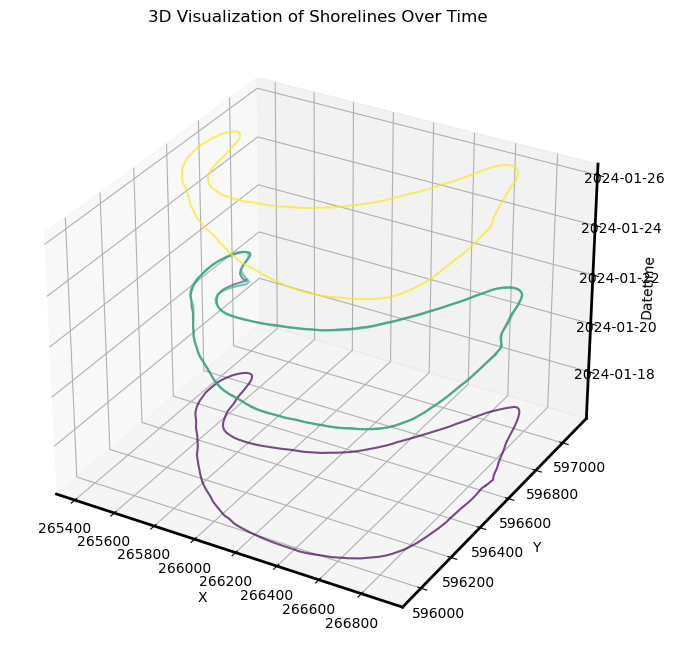

In [13]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert datetimes to numeric values (e.g., matplotlib date numbers)
import matplotlib.dates as mdates
datetime_nums = [mdates.date2num(dt) for dt, _ in shoreline_info]

for idx, (dt, fname) in enumerate(shoreline_info):

    # Get corresponding spline
    spline = shoreline_splines[idx]
    # Use x, y from spline
    x = spline[:, 0]
    y = spline[:, 1]
    # Use the same datetime for all points in this shoreline
    z = np.full_like(x, mdates.date2num(dt), dtype=float)
    # if defective, plot in red
    if fname in defective_files:
        ax.plot(x, y, z, label=fname if idx < 10 else None, alpha=0.7, color='red')
    else:
        color = plt.cm.viridis(idx / max(len(shoreline_info) - 1, 1))
        ax.plot(x, y, z, label=fname if idx < 10 else None, alpha=0.7, color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Datetime')
ax.set_title('3D Visualization of Shorelines Over Time')
ax.zaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

## calculate tidal offsets for datetimes

In [19]:
## mount bucket
!mkdir -p /home/walter_littor_al/tide_model
!gcsfuse --implicit-dirs --dir-mode 777 --file-mode 777 aviso-fes2022 /home/walter_littor_al/tide_model

{"timestamp":{"seconds":1758128209,"nanos":57878285},"severity":"INFO","message":"Start gcsfuse/3.1.0 (Go version go1.24.0) for app \"\" using mount point: /home/walter_littor_al/tide_model\n"}
{"timestamp":{"seconds":1758128209,"nanos":57921488},"severity":"INFO","message":"GCSFuse config","config":{"AppName":"","CacheDir":"","Debug":{"ExitOnInvariantViolation":false,"Fuse":false,"Gcs":false,"LogMutex":false},"DisableAutoconfig":false,"EnableAtomicRenameObject":true,"EnableGoogleLibAuth":false,"EnableHns":true,"EnableNewReader":false,"FileCache":{"CacheFileForRangeRead":false,"DownloadChunkSizeMb":200,"EnableCrc":false,"EnableODirect":false,"EnableParallelDownloads":false,"ExperimentalExcludeRegex":"","ExperimentalParallelDownloadsDefaultOn":true,"MaxParallelDownloads":16,"MaxSizeMb":-1,"ParallelDownloadsPerFile":16,"WriteBufferSize":4194304},"FileSystem":{"DirMode":"777","DisableParallelDirops":false,"ExperimentalEnableDentryCache":false,"ExperimentalEnableReaddirplus":false,"FileMod

In [20]:
import sys
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import littoral_tide_correction

In [28]:
## get a list of datetimes for tide modeling

import pandas as pd

# Load the processing.csv file
csv_path = f"{save_path}/{site_name}/processing.csv"
df_proc = pd.read_csv(csv_path)

# Extract image names
image_names = df_proc['name'] if 'name' in df_proc.columns else df_proc.iloc[:, 0]

# get the characters before the first underscore for each name
sample_date_strs = image_names.str.split('_').str[0]
# parse into a datetime object
times = pd.to_datetime(sample_date_strs, format='%Y%m%dT%H%M%S', utc=True)
times


0   2024-01-16 05:21:49+00:00
1   2024-01-21 05:21:11+00:00
2   2024-01-21 05:21:11+00:00
3   2024-01-26 05:21:09+00:00
Name: name, dtype: datetime64[ns, UTC]

In [31]:
## get the center of the island to locate the tide model

import json
center_location = None
#get the aoi from the json file
with open(f"{save_path}/{site_name}/{site_name}.json") as f:
    settings = json.load(f)
    aoi = settings['aoi']
    center_location = [sum(x) / len(x) for x in zip(*aoi)]

center_location


[72.9015, 5.38275]

In [33]:
# Convert times to numpy datetime64 array for pyTMD compatibility
times_array = times.dt.tz_localize(None).to_numpy()  # Remove timezone and convert to numpy array

# Fix PROJ database context issue for tide modeling
import os
from pyproj import datadir
os.environ['PROJ_DATA'] = '/opt/conda/envs/littoral_pipeline/share/proj'
datadir.set_data_dir('/opt/conda/envs/littoral_pipeline/share/proj')

tide_df = littoral_tide_correction.model_tides(
    center_location[1], 
    center_location[0],
    times_array,  # Use the converted array
    model="fes2022b",
    directory="/home/walter_littor_al/tide_model",
    epsg=4326,
    method="bilinear",
    extrapolate=True,
    cutoff=10.0,
)

In [34]:
tide_df = littoral_tide_correction.calculate_tide_corrections(tide_df,reference_elevation=0,beach_slope=0.08)
tide_df.head()

,dates,x,y,tide,cross_distance
0,2024-01-16 05:21:49+00:00,5.38275,72.9015,0.245706,3.071327
1,2024-01-21 05:21:11+00:00,5.38275,72.9015,0.002874,0.035923
2,2024-01-21 05:21:11+00:00,5.38275,72.9015,0.002874,0.035923
3,2024-01-26 05:21:09+00:00,5.38275,72.9015,-0.365538,-4.569230


In [35]:
# save tide_df to csv
csv_path = f"{save_path}/{site_name}/tide_corrections.csv"
tide_df.to_csv(csv_path, index=False)
csv_path

'/home/walter_littor_al/geotools_sites/Fenfushi/tide_corrections.csv'

In [36]:
!fusermount -u /home/walter_littor_al/tide_model

1878.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## offsetting shorelines for tides

In [14]:
import sys
sys.path.append('/home/walter_littor_al/Littoral_S2download/src')
from littoral import littoral_tide_correction

In [15]:
tidal_corrections_csv = f"{save_path}/{site_name}/tide_corrections.csv"

if os.path.exists(tidal_corrections_csv):
    print(f"Using tidal corrections from: {tidal_corrections_csv}")
    
    # Apply tidal corrections to filtered shorelines
    corrected_shoreline_paths = littoral_tide_correction.apply_tidal_corrections_to_shorelines(
        filtered_shoreline_files=filtered_geo_files,
        shoreline_path=shoreline_path,
        tidal_corrections_path=tidal_corrections_csv,
        output_folder="TIDAL_CORRECTED"
    )
    print(f"Corrected shorelines saved to: {len(corrected_shoreline_paths)} files")
    
else:
    print(f"Tidal corrections file not found at: {tidal_corrections_csv}")
    print("Please run the tidal modeling section first to generate tide corrections.")

Using tidal corrections from: /home/walter_littor_al/geotools_sites/Fenfushi/tide_corrections.csv
Loaded tidal corrections with 4 entries
Created output directory: /home/walter_littor_al/geotools_sites/Fenfushi/TIDAL_CORRECTED
Processing 1/4: 20240116T052149_20240116T053608_T43NBF_nir_geo.csv
  Tidal correction: 3.071 m
  Saved corrected shoreline: 20240116T052149_20240116T053608_T43NBF_nir_geo_tidal_corrected.csv
Processing 2/4: 20240121T052111_20240121T053340_T43NBF_nir_geo.csv
  Tidal correction: 0.036 m
  Saved corrected shoreline: 20240116T052149_20240116T053608_T43NBF_nir_geo_tidal_corrected.csv
Processing 2/4: 20240121T052111_20240121T053340_T43NBF_nir_geo.csv
  Tidal correction: 0.036 m
  Saved corrected shoreline: 20240121T052111_20240121T053340_T43NBF_nir_geo_tidal_corrected.csv
Processing 3/4: 20240121T052111_20240121T053340_T43NBG_nir_geo.csv
  Tidal correction: 0.036 m
  Saved corrected shoreline: 20240121T052111_20240121T053340_T43NBF_nir_geo_tidal_corrected.csv
Processin

## visualize tidally corrected shorelines

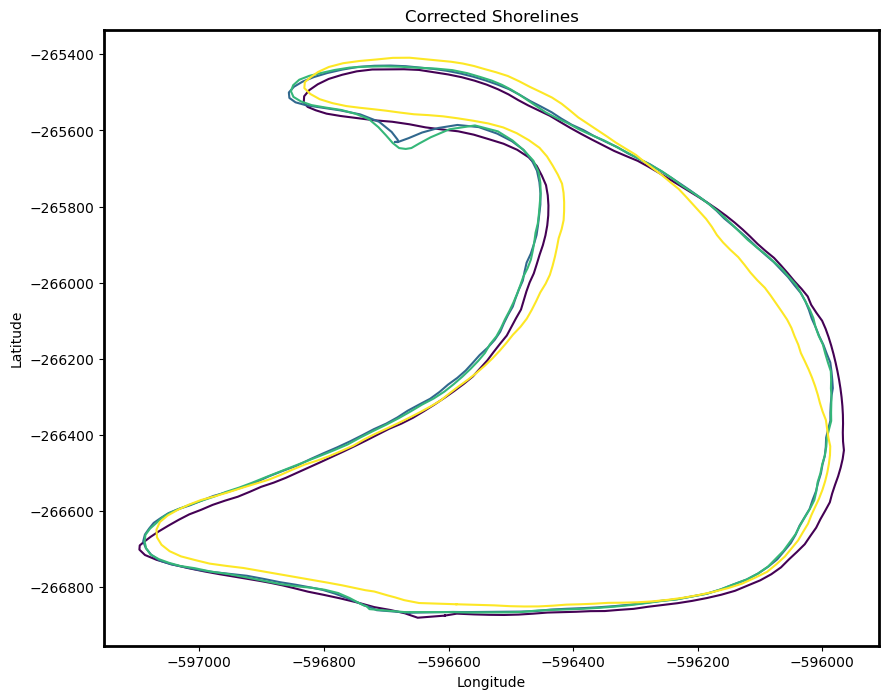

In [16]:
#visualize corrected shorelines
import pandas as pd
import os
import matplotlib.pyplot as plt
corrected_shoreline_folder = shoreline_path.replace("SHORELINE","TIDAL_CORRECTED")
corrected_files = [f for f in os.listdir(corrected_shoreline_folder) if f.endswith('_tidal_corrected.csv')]

plt.figure(figsize=(10, 8))
for idx, csv_file in enumerate(corrected_files):
    csv_path = os.path.join(corrected_shoreline_folder, csv_file)
    df = pd.read_csv(csv_path)
    x = df.iloc[:, 1].tolist()
    y = df.iloc[:, 0].tolist()

    # Invert the y-axis
    y = [-val for val in y]
    x = [-val for val in x]

    # Close the curve by appending the first point to the end
    x.append(x[0])
    y.append(y[0])
    color = plt.cm.viridis(idx / max(len(corrected_files) - 1, 1))
    plt.plot(x, y, linestyle='-', label=csv_file, color=color)

plt.title("Corrected Shorelines")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

## unmount bucket with gcfuse

In [16]:
!fusermount -u /home/walter_littor_al/geotools_sites